**TensorFlow tuto:** https://www.tensorflow.org/tutorials/generative/cyclegan 

# Main libraries

In [ ]:
#allows to import generator and discriminator
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from os import listdir
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import vstack
from numpy import asarray
from numpy import savez_compressed
import numpy as np
from PIL import Image

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

# Load and preprocess dataset

**Needed the first time**

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
  data_list = list()
	# enumerate filenames in directory, assume all are images
  for filename in listdir(path):
    # load and resize the image
	  pixels = load_img(path + filename, target_size=size)
	  # convert to numpy array
	  pixels = img_to_array(pixels)
	  # store
	  data_list.append(pixels)
  return asarray(data_list)

In [ ]:
# dataset path
path = '/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/'
# load dataset white light
# here A: white light, B: nbi light
train_WL = load_images(path + 'train_WL/')
test_WL = load_images(path + 'test_WL/')
########dataA = vstack((dataA1, dataA2))
########print('Loaded dataA: ', dataA.shape)
# load dataset B
train_NBI = load_images(path + 'train_NBI/')
test_NBI = load_images(path + 'test_NBI/')
########dataB = vstack((dataB1, dataB2))
########print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
#filename = '/content/drive/MyDrive/Maestria/Polyps/experiments/data/white2nbi_256.npz'
#savez_compressed(filename, dataA, dataB)
#print('Saved dataset: ', filename)
print("train WL: ", train_WL.shape)
print("train NBI: ", train_NBI.shape)
print("test WL: ", test_WL.shape)
print("testNBIL: ", test_NBI.shape)

train WL:  (1188, 256, 256, 3)
train NBI:  (1188, 256, 256, 3)
test WL:  (295, 256, 256, 3)
testNBIL:  (295, 256, 256, 3)


**Saving data**

In [ ]:
# save numpy array 
from numpy import asarray
from numpy import savetxt
# save np
np.save('train_WL', train_WL)
np.save('train_NBI', train_NBI)
np.save('test_WL', test_WL)
np.save('test_NBI', test_NBI)

In [ ]:
test_NBI = np.load('/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/test_NBI.npy')
test_WL = np.load('/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/test_WL.npy')
train_NBI = np.load('/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/train_NBI.npy')
train_WL = np.load('/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/train_WL.npy')

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

**Data augmentation techniques**

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# scaling the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

**Preprocess splits**

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  return image

In [ ]:
#conversion de las imageness a array
train_WL_array = np.asarray(train_WL)
test_WL_array = np.asarray(test_WL)
train_NBI_array = np.asarray(train_NBI)
test_NBI_array = np.asarray(test_NBI)

In [ ]:
#Crea un dataSet de WL y NBI 
train_WL_ds = tf.data.Dataset.from_tensor_slices(train_WL_array)
train_NBI_ds = tf.data.Dataset.from_tensor_slices(train_NBI_array)
test_WL_ds = tf.data.Dataset.from_tensor_slices(test_WL_array)
test_NBI_ds = tf.data.Dataset.from_tensor_slices(test_NBI_array)

In [ ]:
train_WL_ds = train_WL_ds.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_NBI_ds = train_NBI_ds.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_WL_ds = test_WL_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_NBI_ds = test_NBI_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_WL = next(iter(train_WL_ds))
sample_NBI = next(iter(train_NBI_ds))

Text(0.5, 1.0, 'Before scaling')

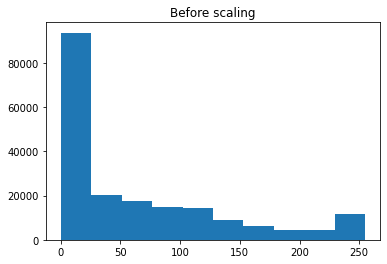

In [ ]:
b = test_NBI_array[0]
plt.hist(b.ravel())
plt.title("Before scaling")

Text(0.5, 1.0, 'After scaling')

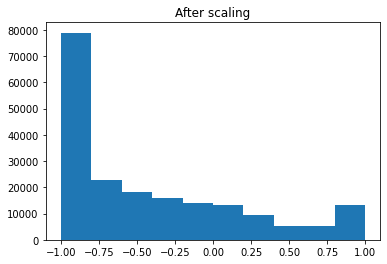

In [ ]:
a = np.array(sample_NBI[0])
plt.hist(a.ravel())
plt.title("After scaling")

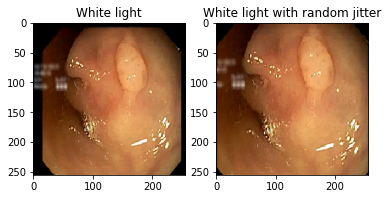

In [ ]:
plt.subplot(121)
plt.title('White light')
plt.imshow(sample_WL[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('White light with random jitter')
plt.imshow(random_jitter(sample_WL[0]) * 0.5 + 0.5)

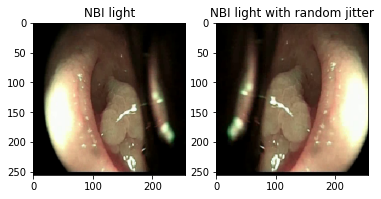

In [ ]:
plt.subplot(121)
plt.title('NBI light')
plt.imshow(sample_NBI[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('NBI light with random jitter')
plt.imshow(random_jitter(sample_NBI[0]) * 0.5 + 0.5)

# Import and reuse the Pix2Pix models

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


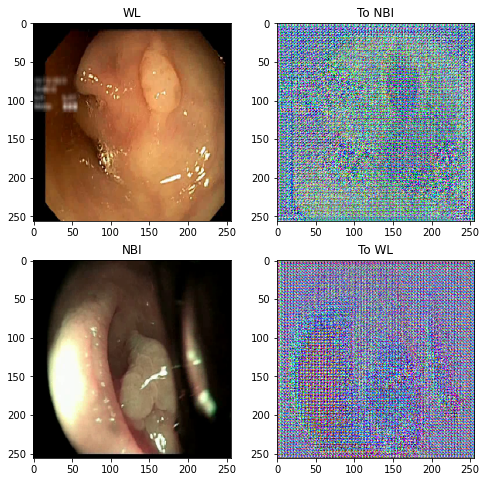

In [ ]:
to_NBI = generator_g(sample_WL)
to_WL = generator_f(sample_NBI)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_WL, to_NBI, sample_NBI, to_WL]
title = ['WL', 'To NBI', 'NBI', 'To WL']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

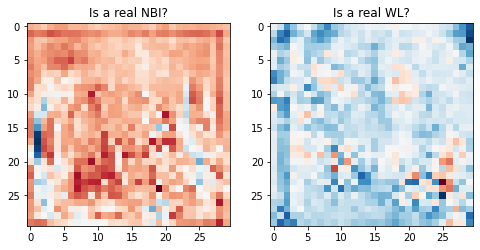

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real NBI?')
plt.imshow(discriminator_y(sample_NBI)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real WL?')
plt.imshow(discriminator_x(sample_WL)[0, ..., -1], cmap='RdBu_r')

plt.show()

## **Loss functions**

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

## **Initializing optimizers, generator and discriminators**

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## **Check points**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Maestria/Polyps/experiments/models"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


# **Training**

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
def train_and_checkpoint(ckpt_manager):
  ckpt.restore(ckpt_manager.latest_checkpoint)
  if ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  for epoch in range(EPOCHS):
    start = time.time()
    n = 0    

    for image_x, image_y in tf.data.Dataset.zip((train_WL_ds, train_NBI_ds)):
      train_step(image_x, image_y)
      if n % 10 == 0:
        print ('.', end='')
      n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_WL)

    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                          ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

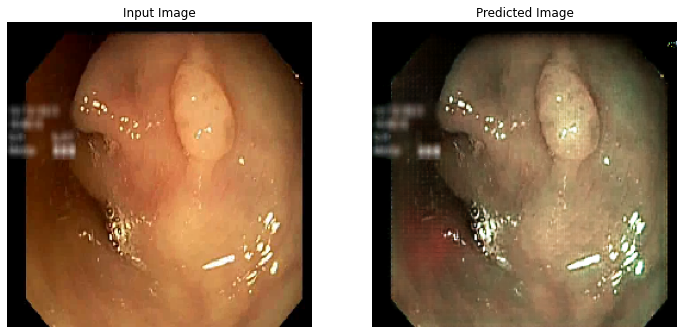

Saving checkpoint for epoch 40 at /content/drive/MyDrive/Maestria/Polyps/experiments/models/ckpt-12
Time taken for epoch 40 is 492.7718732357025 sec



In [ ]:
train_and_checkpoint(ckpt_manager)

# **Generate using test dataset**

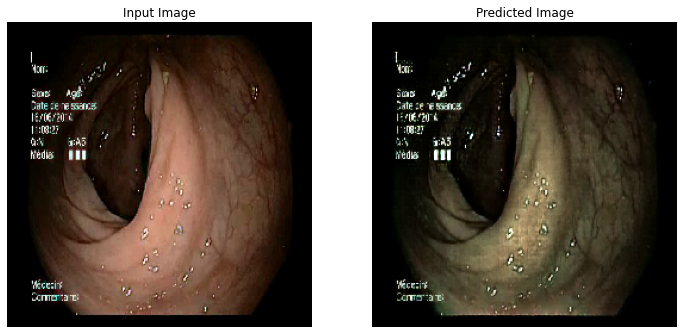

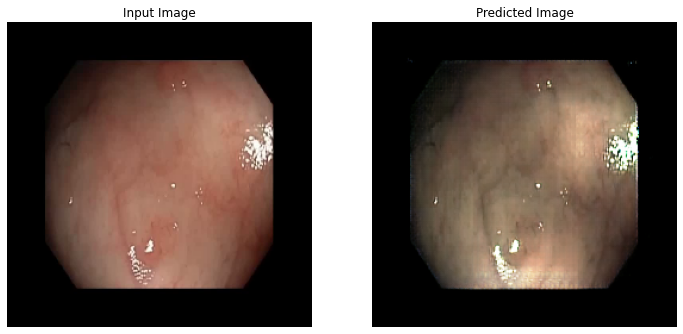

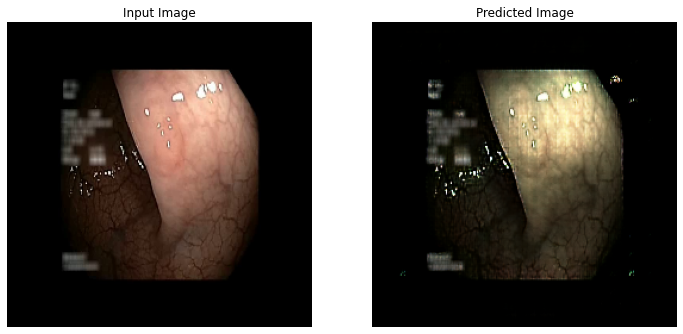

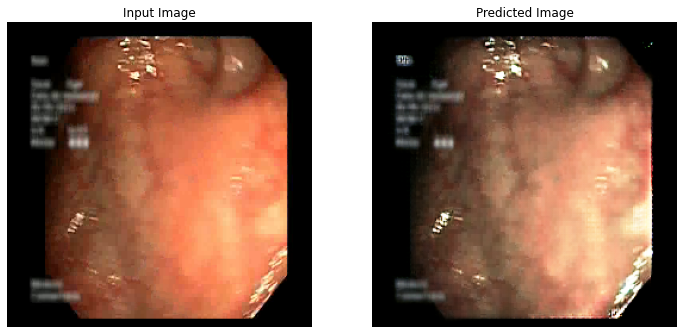

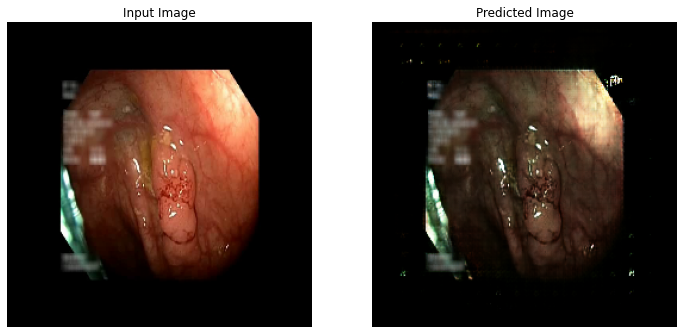

In [ ]:
# Run the trained model on the test dataset
for inp in test_WL_ds.take(5):
  generate_images(generator_g, inp)

# **Predicting over full frames video**

In [ ]:
# frames from video path
path = '/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/adenomaWL_prueba/real_imgs/'
# load dataset white light
# here A: white light, B: nbi light
adenoma_WL = load_images(path + 'video_1/')
print("Adenoma WL video_1: ", adenoma_WL.shape)

Adenoma WL video_1:  (175, 256, 256, 3)


In [ ]:
adenoma_WL_array = np.asarray(adenoma_WL)
adenoma_WL_ds = tf.data.Dataset.from_tensor_slices(adenoma_WL_array)
adenoma_WL_ds = adenoma_WL_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Run the trained model on the test dataset
path_solve = '/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/adenomaWL_prueba/fake_imgs/'
folder = 'video_1_fake/'
path_img_solved = path_solve + folder


for count, inp in enumerate(adenoma_WL_ds.take(-1)):
  fake = generator_g(inp)
  fake = fake[0]* 0.5 + 0.5
  #para que PIL Image deje guardar (mult por 255 and change by uint8)
  fake = np.array(fake) * 255
  fake = fake.astype(np.uint8)
  fake_img = Image.fromarray(fake)
  name_file = path_img_solved + 'img_' + str(count) + '.png' 
  fake_img.save(name_file)

(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 

**Creating video from fake frames predicted**

In [ ]:
import cv2
import numpy as np
import glob

img_array = []
for filename in glob.glob('/content/drive/MyDrive/Maestria/Polyps/experiments/data/wl2Nbi/adenomaWL_prueba/fake_imgs/video_1_fake/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 7, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()